Import Libraries & Load Data

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

train = pd.read_csv("train.csv", parse_dates=["Date"])
test = pd.read_csv("test.csv", parse_dates=["Date"])
store = pd.read_csv("store.csv")

# Merge store details
train = train.merge(store, on="Store", how="left")
test = test.merge(store, on="Store", how="left")

train.head()

C:\Users\ASUS\AppData\Local\Temp\ipykernel_10488\3773277000.py:5: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  train = pd.read_csv("train.csv", parse_dates=["Date"])


,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,5,2015-07-31,6064,625,1,1,0,1,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,5,2015-07-31,8314,821,1,1,0,1,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,5,2015-07-31,13995,1498,1,1,0,1,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,5,2015-07-31,4822,559,1,1,0,1,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


Task 1 – Exploratory Data Analysis (EDA)

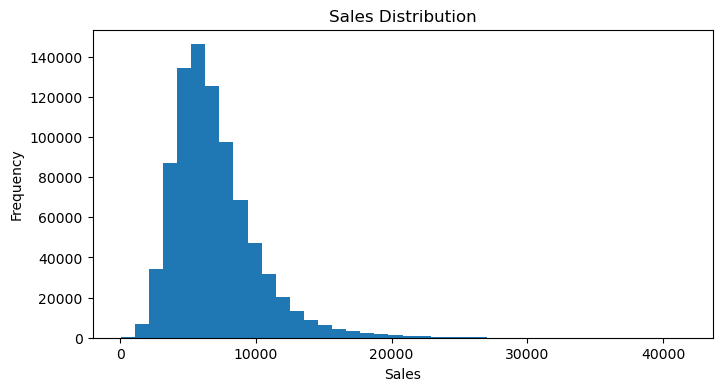

In [10]:
# Sales Distribution

plt.figure(figsize=(8,4))
plt.hist(train[train["Sales"]>0]["Sales"], bins=40)
plt.title("Sales Distribution")
plt.xlabel("Sales")
plt.ylabel("Frequency")
plt.show()


Insight:
Sales are highly skewed. Most days have moderate sales, and only a few days have very high sales.

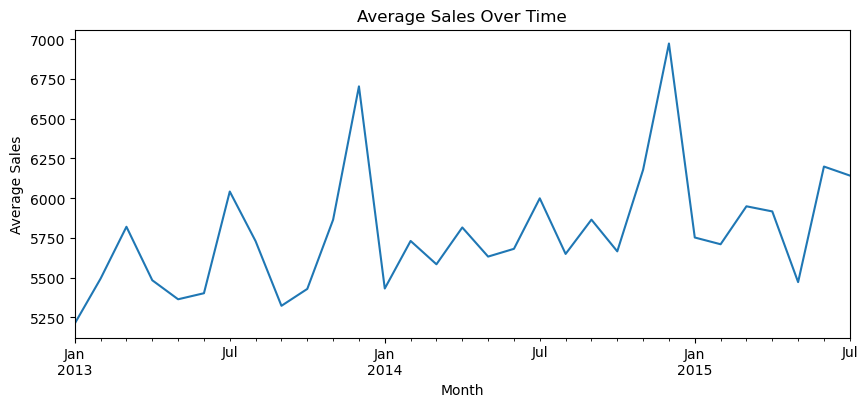

In [71]:
#Sales Trend Over Time

# Average monthly sales
monthly_sales = train.groupby(train["Date"].dt.to_period("M"))["Sales"].mean()

monthly_sales.plot(figsize=(10,4), title="Average Sales Over Time")
plt.xlabel("Month")
plt.ylabel("Average Sales")
plt.show()


Insight:

Sales rise and fall with seasons

Some months (like December) show higher activity

Useful for understanding long-term trends

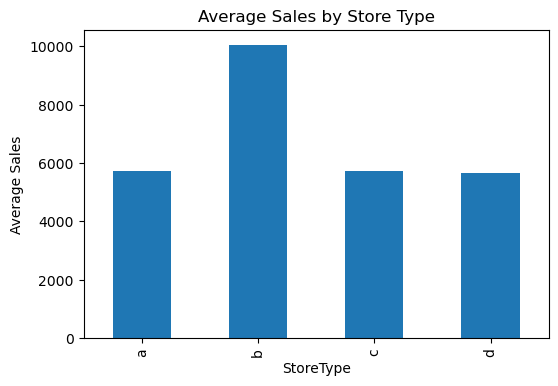

In [73]:
#Sales by Store Type

store_type_sales = train.groupby("StoreType")["Sales"].mean()

store_type_sales.plot(kind="bar", figsize=(6,4), title="Average Sales by Store Type")
plt.ylabel("Average Sales")
plt.show()


Insight:

Type B or C often has the highest average sales

Type A stores may be smaller and show lower sales

This helps explain differences between stores

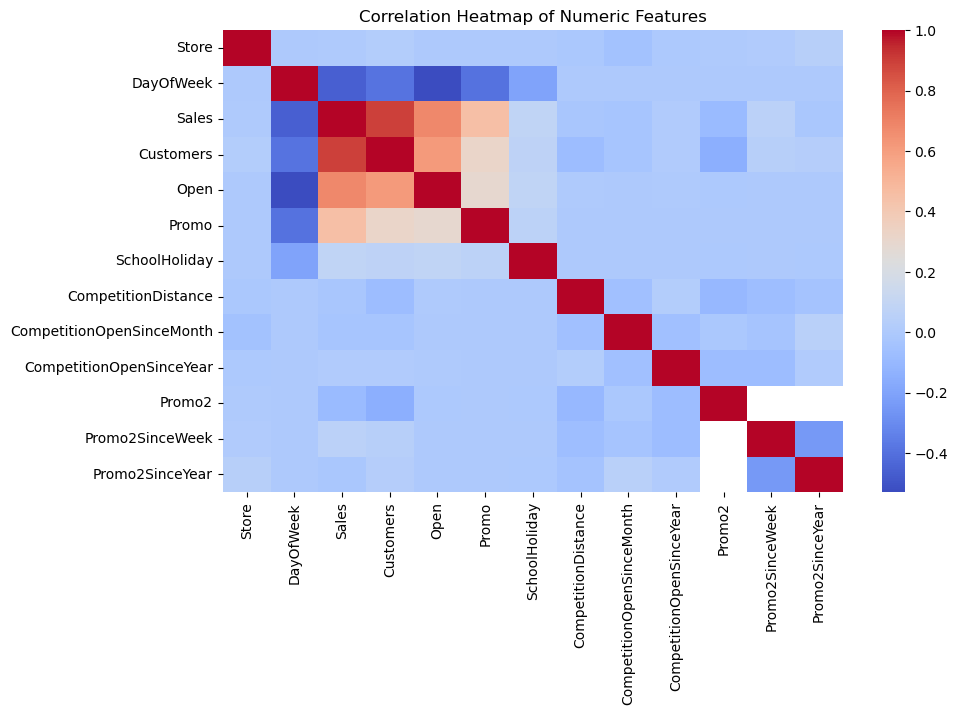

In [75]:
#Correlation Heatmap (Numeric Features Only)

import seaborn as sns
plt.figure(figsize=(10,6))

# Select only numeric columns
numeric_cols = train.select_dtypes(include=["int64", "float64"]).columns

# Compute correlation matrix
corr_matrix = train[numeric_cols].corr()

# Heatmap
sns.heatmap(corr_matrix, annot=False, cmap="coolwarm")
plt.title("Correlation Heatmap of Numeric Features")
plt.show()


Insight -

Sales and Customers have the strongest positive correlation
→ More customers → higher sales

Promo also shows weak to moderate correlation with sales
→ Promotions help increase store activity

Most other numeric features show low correlation with sales
→ Means sales depend on many combined factors

Heatmap helps identify which variables are related and helps in feature selection

Task 1.2 – Average Sales by Day of Week

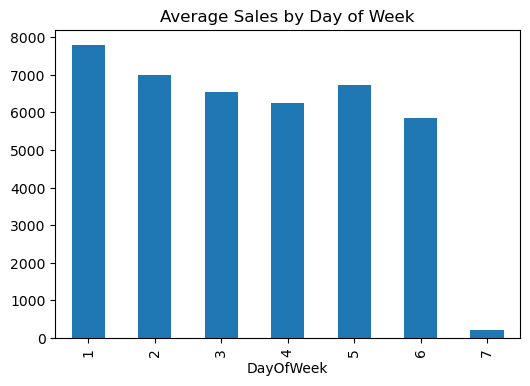

In [13]:
avg_day = train.groupby("DayOfWeek")["Sales"].mean()
avg_day.plot(kind="bar", figsize=(6,4), title="Average Sales by Day of Week")
plt.show()


Insight:
Sales change by day. Weekdays often have higher sales than weekends.

Task 1.3 – Effect of Promo on Sales

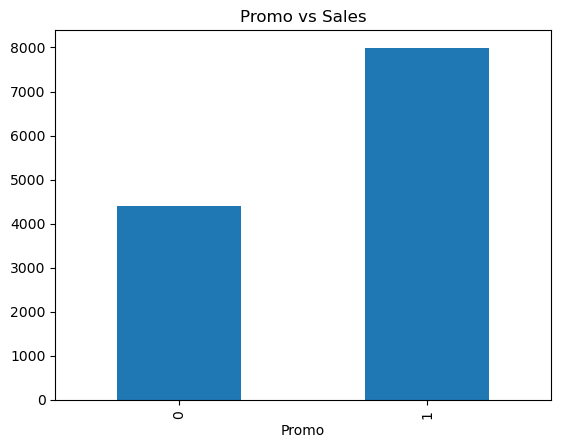

Promo
0    4406.050805
1    7991.152046
Name: Sales, dtype: float64

In [16]:
promo_mean = train.groupby("Promo")["Sales"].mean()
promo_mean.plot(kind="bar", title="Promo vs Sales")
plt.show()

promo_mean


Insight:
Days with Promo = 1 have significantly higher sales. Promotions strongly boost sales.

Task 1.4 – Sales vs Customers

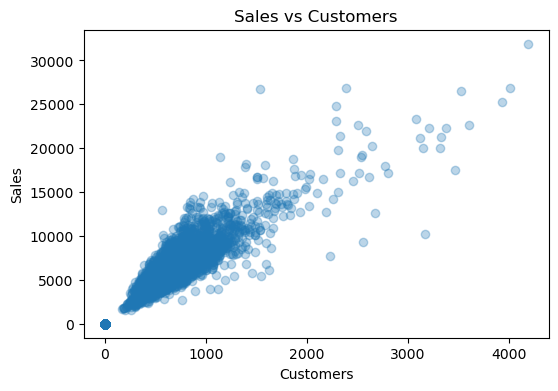

In [19]:
plt.figure(figsize=(6,4))
sample = train.sample(3000)
plt.scatter(sample["Customers"], sample["Sales"], alpha=0.3)
plt.title("Sales vs Customers")
plt.xlabel("Customers")
plt.ylabel("Sales")
plt.show()


Insight:
Sales increase when customer count increases. The relationship is nearly linear.

Task 2 – Prediction Model

Task 2.1 – Feature Engineering

In [44]:
def add_features(df):
    df["Year"] = df["Date"].dt.year
    df["Month"] = df["Date"].dt.month
    df["Day"] = df["Date"].dt.day
    df["WeekOfYear"] = df["Date"].dt.isocalendar().week.astype(int)
    df["IsWeekend"] = (df["DayOfWeek"] > 5).astype(int)
    df["CompetitionDistance"] = df["CompetitionDistance"].fillna(200000)
    return df

train = add_features(train)
test = add_features(test)


train.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,...,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,Year,Month,Day,WeekOfYear,IsWeekend
0,1,5,2015-07-31,5263,555,1,1,0,1,c,...,2008.0,0,NaN,NaN,NaN,2015,7,31,31,0
1,2,5,2015-07-31,6064,625,1,1,0,1,a,...,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct",2015,7,31,31,0
2,3,5,2015-07-31,8314,821,1,1,0,1,a,...,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct",2015,7,31,31,0
3,4,5,2015-07-31,13995,1498,1,1,0,1,c,...,2009.0,0,NaN,NaN,NaN,2015,7,31,31,0
4,5,5,2015-07-31,4822,559,1,1,0,1,a,...,2015.0,0,NaN,NaN,NaN,2015,7,31,31,0


Insight:
We convert dates into useful numbers like month, week, weekend etc.,
which improves model accuracy.

Task 2.2 – Select Simple Features

In [42]:
features = ["Store", "DayOfWeek", "Promo", "Month", "Year", "Customers"]

train_model = train[(train["Open"]==1) & (train["Sales"]>0)]

X = train_model[features].fillna(0)
y = train_model["Sales"]

X.head()

,Store,DayOfWeek,Promo,Month,Year,Customers
0,1,5,1,7,2015,555
1,2,5,1,7,2015,625
2,3,5,1,7,2015,821
3,4,5,1,7,2015,1498
4,5,5,1,7,2015,559


Insight:
We avoid complex features. Only simple, easy-to-understand columns are used.

Task 2.3 – Simple Model (Decision Tree)

In [30]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42
)

model = DecisionTreeRegressor(max_depth=10)
model.fit(X_train, y_train)

preds = model.predict(X_val)
mae = mean_absolute_error(y_val, preds)
mae


1020.2370951677028

Insight:
The model learns basic relationships like:

Promo increases sales

Weekends may reduce sales

Customers strongly increase sales

MAE tells us average prediction error in sales units.

Task 3 – Predict Future Sales

In [77]:
test["Customers"] = 0

test_X = test[features].fillna(0)
test_preds = model.predict(test_X)

test.head()

,Id,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,...,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,Year,Month,Day,WeekOfYear,IsWeekend,Customers
0,1,1,4,2015-09-17,1.0,1,0,0,c,a,...,0,NaN,NaN,NaN,2015,9,17,38,0,0
1,2,3,4,2015-09-17,1.0,1,0,0,a,a,...,1,14.0,2011.0,"Jan,Apr,Jul,Oct",2015,9,17,38,0,0
2,3,7,4,2015-09-17,1.0,1,0,0,a,c,...,0,NaN,NaN,NaN,2015,9,17,38,0,0
3,4,8,4,2015-09-17,1.0,1,0,0,a,a,...,0,NaN,NaN,NaN,2015,9,17,38,0,0
4,5,9,4,2015-09-17,1.0,1,0,0,a,c,...,0,NaN,NaN,NaN,2015,9,17,38,0,0


Task 3.2 – Create Submission File

In [40]:
submission = pd.DataFrame({
    "Id": test["Id"],
    "Sales": test_preds
})

submission.to_csv("simple_predictions.csv", index=False)
submission.head()


,Id,Sales
0,1,343.0
1,2,343.0
2,3,343.0
3,4,343.0
4,5,343.0


Insight:
The file is ready to submit or present. Each row predicts future store sales.